# Import Packages

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
# For Prediction:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool
# For nice Plots
%matplotlib inline
plt.style.use('default')

# Read in the Data

In [2]:
dir_path = os.path.abspath("")
fname = dir_path+'\countrydf.csv'
countrydf = pd.read_csv(fname, encoding='latin-1')
countrydf = countrydf.loc[:, ~countrydf.columns.str.contains('^Unnamed')]
#countrydf = countrydf.drop(["Country", "Year"],axis=1)

# Prediction:

In [3]:
# Build a test set and training set

cols_to_standardize = countrydf.columns.drop(['Country', 'Year','Future Undernourishment'])
scaler = StandardScaler()
countrydf[cols_to_standardize] = scaler.fit_transform(countrydf[cols_to_standardize])

# Print the standardized dataframe
print(countrydf)

X_train, X_test, y_train, y_test = train_test_split(
  countrydf.drop(["Future Undernourishment"], axis=1), countrydf["Future Undernourishment"], test_size=1/3, random_state = 42)

# Replace all the NaNs with the column mean, 
# and build the test set and training set using the indicies from the first set
countrydf2 = countrydf.fillna(countrydf.mean())
# Build a test set and training set
X_train2 = countrydf2.drop(["Future Undernourishment"], axis=1).iloc[X_train.index]
X_test2 = countrydf2.drop(["Future Undernourishment"], axis=1).iloc[X_test.index]
y_train2 = countrydf2["Future Undernourishment"].iloc[y_train.index]
y_test2 = countrydf2["Future Undernourishment"].iloc[y_test.index]

# Use only rows with non-NaN response variable, then replace all the NaNs with the column mean 
# and build the test set and training set using the indicies from the first set
keep_indices_test = np.where(y_test.notna())
keep_indices_train = np.where(y_train.notna())
# Build a test set and training set
X_train3 = X_train2.iloc[keep_indices_train]
X_test3 = X_test2.iloc[keep_indices_test]
y_train3 = y_train2.iloc[keep_indices_train]
y_test3 = y_test2.iloc[keep_indices_test]

      Country  Year  \
0     Algeria  2002   
1     Algeria  2003   
2     Algeria  2004   
3     Algeria  2005   
4     Algeria  2006   
...       ...   ...   
1075   Africa  2017   
1076   Africa  2018   
1077   Africa  2019   
1078   Africa  2020   
1079   Africa  2001   

      Average dietary energy supply adequacy (percent) (3-year average)  \
0                                              1.031639                   
1                                              1.169786                   
2                                              1.238859                   
3                                              1.238859                   
4                                              1.307932                   
...                                                 ...                   
1075                                           0.202758                   
1076                                           0.202758                   
1077                                           0

C:\Users\stvp2\AppData\Local\Temp\ipykernel_39252\2885630094.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  countrydf2 = countrydf.fillna(countrydf.mean())


## 0. Baseline: Using previous year's undernouishment to predict next year

In [4]:
Future_Undernourishment_Col_Name = "Prevalence of undernourishment (percent) (3-year average)"
y_hat_baseline = X_test[Future_Undernourishment_Col_Name]*0
RMSE_baseline = np.sqrt((np.sum(y_hat_baseline-y_test)**2)/len(y_hat_baseline))
print("Baseline RMSE: "+str(RMSE_baseline))

Baseline RMSE: 4.295427155062048


In [5]:
y_hat_baseline2 = X_test2[Future_Undernourishment_Col_Name]*0
RMSE_baseline2 = np.sqrt((np.sum(y_hat_baseline2-y_test2)**2)/len(y_hat_baseline2))
print("Baseline RMSE2 (replacing all NaNs with mean): "+str(RMSE_baseline2))

Baseline RMSE2 (replacing all NaNs with mean): 5.370450254368094


In [6]:
y_hat_baseline3 = X_test3[Future_Undernourishment_Col_Name]*0
RMSE_baseline3 = np.sqrt((np.sum(y_hat_baseline3-y_test3)**2)/len(y_hat_baseline3))
print("Baseline RMSE3 (removing NaN in repsonse, then replacing all NaNs with mean): "+str(RMSE_baseline3))

Baseline RMSE3 (removing NaN in repsonse, then replacing all NaNs with mean): 4.932604391250738


## 1. CatBoost

In [7]:
catb = CatBoostRegressor(iterations=200,
                          learning_rate=.4,
                          depth=5,
                          random_state=42)

pool_train = Pool(X_train2, y_train2,
                  cat_features = ['Country', 'Year'])

pool_test = Pool(X_test2, cat_features = ['Country', 'Year'])                          

catb.fit(pool_train)
y_hat_catb2 = catb.predict(pool_test)
RMSE_catb2 = np.sqrt((np.sum(y_hat_catb2-y_test2)**2)/len(y_hat_catb2))
print("Baseline RMSE2: "+str(RMSE_baseline2))
print("CatBoost RMSE2: "+str(RMSE_catb2))

0:	learn: 1.3207216	total: 156ms	remaining: 31.1s
1:	learn: 1.2333556	total: 175ms	remaining: 17.4s
2:	learn: 1.1740335	total: 198ms	remaining: 13s
3:	learn: 1.1216922	total: 221ms	remaining: 10.8s
4:	learn: 1.0993723	total: 241ms	remaining: 9.4s
5:	learn: 1.0758039	total: 263ms	remaining: 8.51s
6:	learn: 1.0621929	total: 285ms	remaining: 7.87s
7:	learn: 1.0217602	total: 308ms	remaining: 7.39s
8:	learn: 0.9887228	total: 330ms	remaining: 7s
9:	learn: 0.9714255	total: 353ms	remaining: 6.7s
10:	learn: 0.9590446	total: 377ms	remaining: 6.48s
11:	learn: 0.9311270	total: 403ms	remaining: 6.32s
12:	learn: 0.9081199	total: 427ms	remaining: 6.14s
13:	learn: 0.8902618	total: 450ms	remaining: 5.97s
14:	learn: 0.8878038	total: 471ms	remaining: 5.81s
15:	learn: 0.8796927	total: 494ms	remaining: 5.68s
16:	learn: 0.8539903	total: 516ms	remaining: 5.56s
17:	learn: 0.8444635	total: 538ms	remaining: 5.44s
18:	learn: 0.8377673	total: 560ms	remaining: 5.33s
19:	learn: 0.8321181	total: 597ms	remaining: 5.3

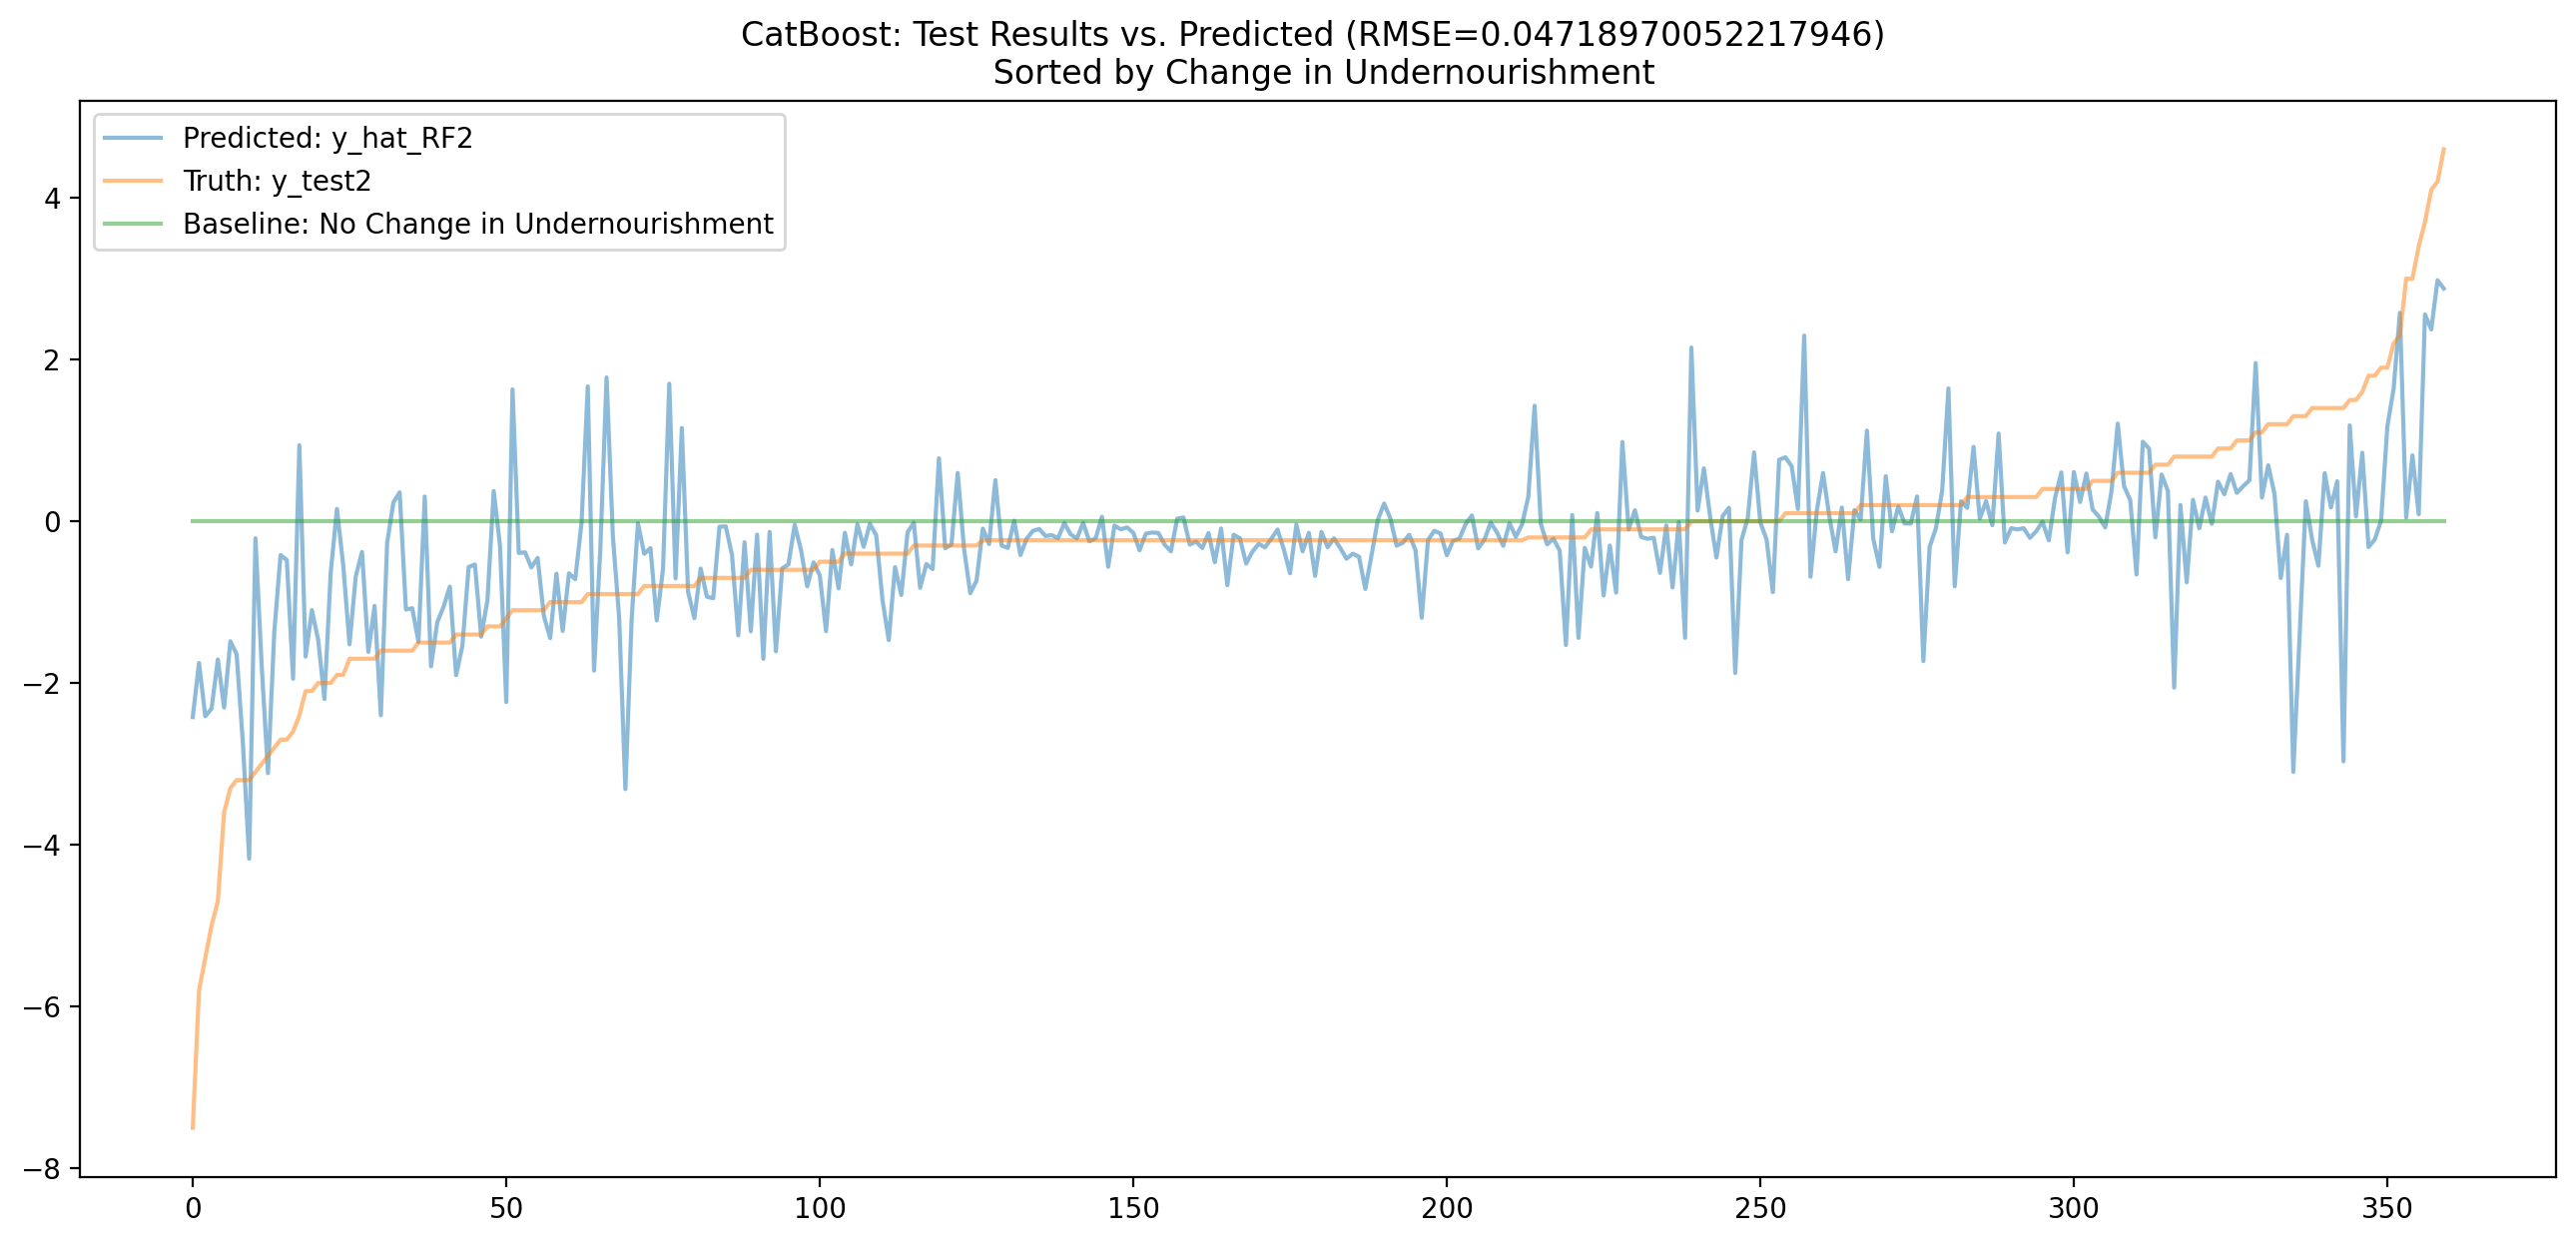

In [8]:
sorted_Idx = np.argsort(y_test2.to_numpy())
plt.figure(figsize=(16, 7), dpi=200)
plt.plot(y_hat_catb2[sorted_Idx], label='Predicted: y_hat_RF2', alpha=0.5)
plt.plot(y_test2.to_numpy()[sorted_Idx], label='Truth: y_test2', alpha=0.5)
plt.plot(y_hat_baseline2.to_numpy()[sorted_Idx], label='Baseline: No Change in Undernourishment', alpha=0.5)
plt.title("CatBoost: Test Results vs. Predicted (RMSE="+str(RMSE_catb2)+") \n Sorted by Change in Undernourishment")
plt.legend();

In [11]:
catb = CatBoostRegressor(iterations=200,
                          learning_rate=.4,
                          depth=10,
                          random_state=42)

pool_train = Pool(X_train3, y_train3,
                  cat_features = ['Country', 'Year'])

pool_test = Pool(X_test3, cat_features = ['Country', 'Year'])                          

catb.fit(pool_train)
y_hat_catb3 = catb.predict(pool_test)
RMSE_catb3 = np.sqrt((np.sum(y_hat_catb3-y_test3)**2)/len(y_hat_catb3))
print("Baseline RMSE3: "+str(RMSE_baseline3))
print("CatBoost RMSE3: "+str(RMSE_catb3))

0:	learn: 1.4527645	total: 67.5ms	remaining: 13.4s
1:	learn: 1.3111370	total: 134ms	remaining: 13.2s
2:	learn: 1.1863897	total: 203ms	remaining: 13.3s
3:	learn: 1.0944663	total: 272ms	remaining: 13.3s
4:	learn: 1.0336865	total: 348ms	remaining: 13.6s
5:	learn: 0.9944585	total: 425ms	remaining: 13.7s
6:	learn: 0.9704676	total: 495ms	remaining: 13.6s
7:	learn: 0.9142021	total: 564ms	remaining: 13.5s
8:	learn: 0.8772590	total: 636ms	remaining: 13.5s
9:	learn: 0.8466613	total: 700ms	remaining: 13.3s
10:	learn: 0.8277719	total: 767ms	remaining: 13.2s
11:	learn: 0.7954440	total: 865ms	remaining: 13.6s
12:	learn: 0.7519861	total: 946ms	remaining: 13.6s
13:	learn: 0.7496220	total: 957ms	remaining: 12.7s
14:	learn: 0.7099210	total: 1.03s	remaining: 12.8s
15:	learn: 0.6601392	total: 1.1s	remaining: 12.6s
16:	learn: 0.6436465	total: 1.16s	remaining: 12.5s
17:	learn: 0.6161342	total: 1.23s	remaining: 12.4s
18:	learn: 0.6056345	total: 1.3s	remaining: 12.4s
19:	learn: 0.5759111	total: 1.36s	remainin

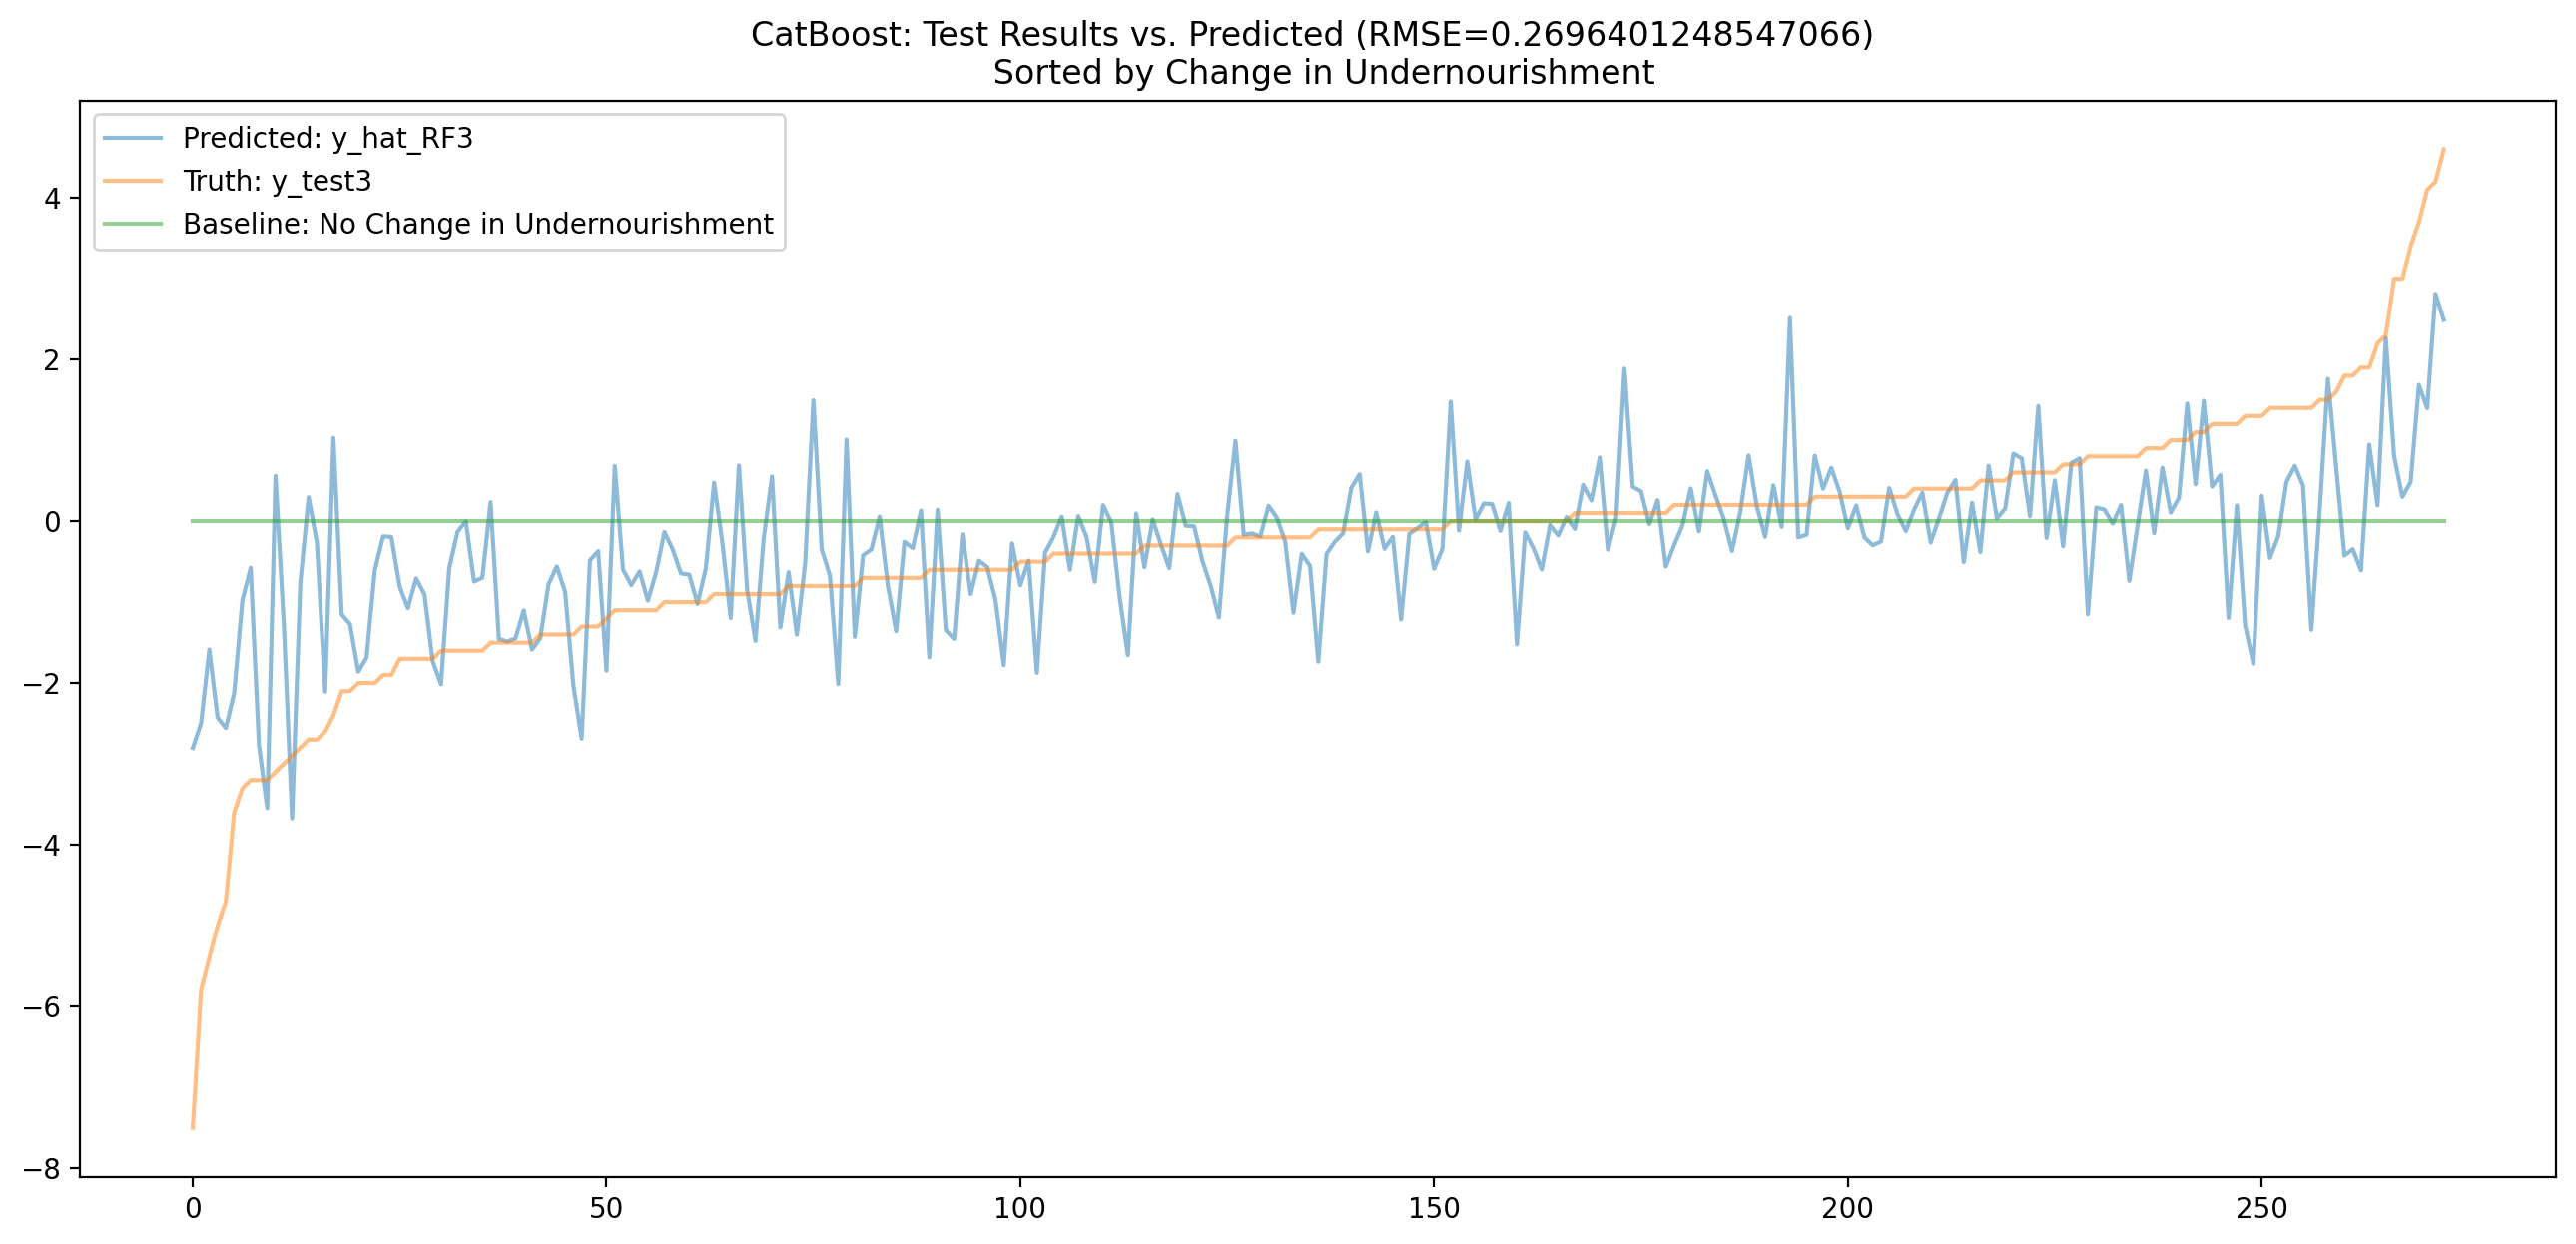

In [12]:
sorted_Idx = np.argsort(y_test3.to_numpy())
plt.figure(figsize=(16, 7), dpi=200)
plt.plot(y_hat_catb3[sorted_Idx], label='Predicted: y_hat_RF3', alpha=0.5)
plt.plot(y_test3.to_numpy()[sorted_Idx], label='Truth: y_test3', alpha=0.5)
plt.plot(y_hat_baseline3.to_numpy()[sorted_Idx], label='Baseline: No Change in Undernourishment', alpha=0.5)
plt.title("CatBoost: Test Results vs. Predicted (RMSE="+str(RMSE_catb3)+") \n Sorted by Change in Undernourishment")
plt.legend();

# Feature Importance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


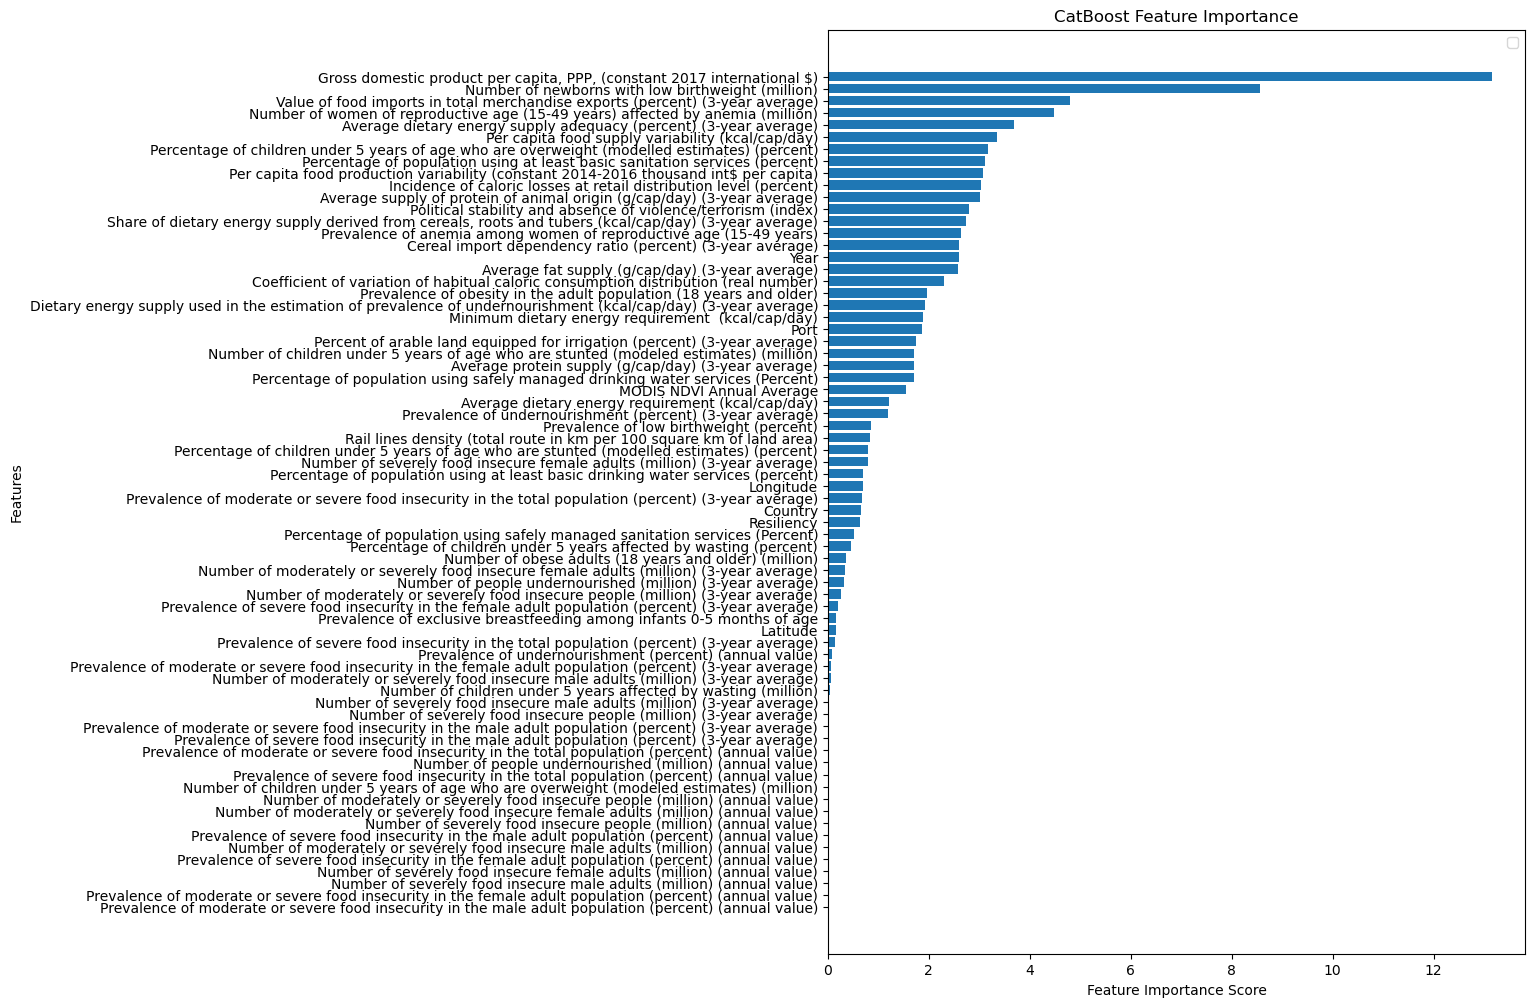

In [18]:
#Create the axis Labels
secFet = countrydf.drop(["Future Undernourishment"], axis=1).columns
#Develope Feature Importance
feature_importance = catb.get_feature_importance()
#Sort High to low
sorted_indices = np.argsort(feature_importance)

# Plot the Feature Importance
fig, ax = plt.subplots(figsize=(9, 12))
ax.barh(secFet[sorted_indices], feature_importance[sorted_indices])
plt.title("CatBoost Feature Importance")
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.legend()
plt.show()